In [1]:
import pandas as pd

df = pd.read_csv("complaints.csv", nrows=5000000, dtype=str)
print(df.shape)
print(df.columns)
print(df.head())

(5000000, 18)
Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')
  Date received                                            Product  \
0    2020-07-06  Credit reporting, credit repair services, or o...   
1    2025-09-24  Credit reporting or other personal consumer re...   
2    2019-12-26                        Credit card or prepaid card   
3    2020-05-08  Credit reporting, credit repair services, or o...   
4    2025-09-23  Credit reporting or other personal consumer re...   

                                  Sub-product  \
0                            Credit reporting   
1                            Credit reporting   
2  General-purpose credit card or c

In [2]:
df = df[["Product", "Consumer complaint narrative"]]
df = df.dropna(subset=["Consumer complaint narrative", "Product"])
print(df.shape)

(1421062, 2)


In [3]:
def map_product(prod):
    prod = prod.lower()
    if "credit reporting" in prod or "credit repair" in prod:
        return 0   # Credit reporting, repair, or other
    elif "debt collection" in prod:
        return 1   # Debt collection
    elif "loan" in prod and "mortgage" not in prod:
        return 2   # Consumer Loan
    elif "mortgage" in prod:
        return 3   # Mortgage
    else:
        return None

df["label"] = df["Product"].apply(map_product)
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

print(df["label"].value_counts())


label
0    941459
1    156448
2     59262
3     57375
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    df["Consumer complaint narrative"], df["label"],
    test_size=0.3, random_state=42, stratify=df["label"]
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

In [5]:
# Take a 10% random sample
df_sample = df.sample(frac=0.10, random_state=42)
print(df_sample.shape)

(121454, 3)


In [6]:
df_sample["text_length"] = df_sample["Consumer complaint narrative"].astype(str).apply(lambda x: len(x.split()))
df_sample["text_length"].describe()

count    121454.000000
mean        171.100293
std         227.217552
min           1.000000
25%          57.000000
50%         110.000000
75%         200.000000
max        5878.000000
Name: text_length, dtype: float64

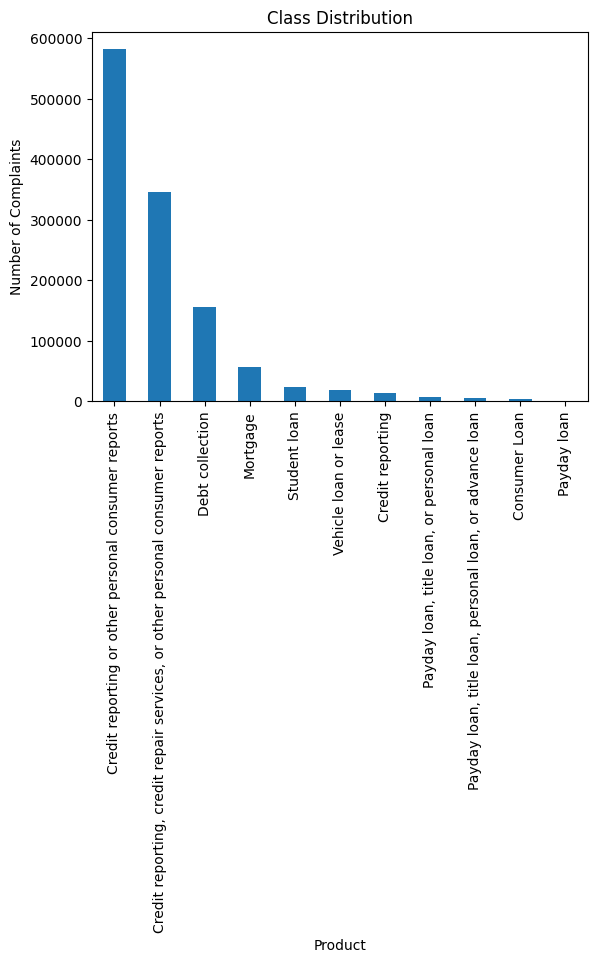

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting class distrubution
df["Product"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.ylabel("Number of Complaints")
plt.show()

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

df_sample["clean_text"] = df_sample["Consumer complaint narrative"].astype(str).apply(preprocess)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,1))  
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
X_test_tfidf  = tfidf.transform(X_test)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_valid_tfidf)
    results[name] = classification_report(y_valid, y_pred, output_dict=True)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_valid, y_pred))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    141219
           1       0.80      0.69      0.74     23467
           2       0.78      0.72      0.75      8889
           3       0.90      0.88      0.89      8607

    accuracy                           0.92    182182
   macro avg       0.86      0.81      0.83    182182
weighted avg       0.91      0.92      0.91    182182


Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.95      0.94    141219
           1       0.74      0.55      0.63     23467
           2       0.62      0.71      0.67      8889
           3       0.82      0.88      0.85      8607

    accuracy                           0.88    182182
   macro avg       0.78      0.77      0.77    182182
weighted avg       0.88      0.88      0.88    182182


SVM Classification Report:

              preci

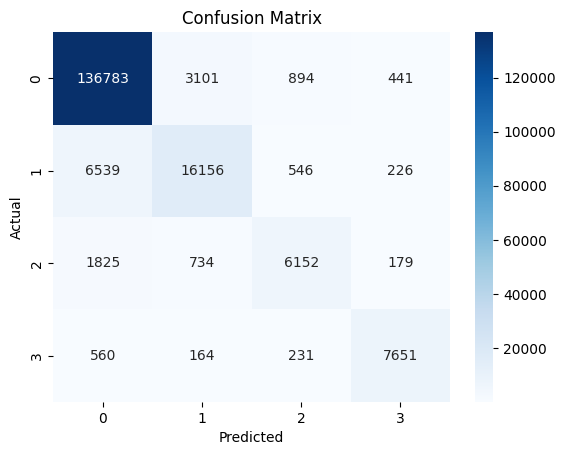

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

best_model = LinearSVC()  # choose the best based on validation
best_model.fit(X_train_tfidf, y_train)
y_pred = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
def predict_complaint(text):
    text_clean = preprocess(text)
    text_tfidf = tfidf.transform([text_clean])
    return best_model.predict(text_tfidf)[0]

label_map = {
    0: "Credit reporting, repair, or other",
    1: "Debt collection",
    2: "Consumer Loan",
    3: "Mortgage"
}

#Test with sample output 
sample = "The bank reported incorrect information on my credit report."
pred = predict_complaint(sample)
print(f"Predicted Category of Narasimha's model:\n{sample} : {label_map[pred]}")

Predicted Category of Narasimha's model:
The bank reported incorrect information on my credit report. : Credit reporting, repair, or other
